In [1]:
%matplotlib nbagg
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import os

In [93]:
# Estimation parameter of PF
Q = np.diag([0.2]) ** 2  # range error
R = np.diag([2.0, np.deg2rad(40.0)]) ** 2  # input error

#  Simulation parameter
Q_sim = np.diag([0.2]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range

# Particle filter parameter
NP = 30  # Number of Particle
NTh = NP / 2.0  # Number of particle for re-sampling

show_animation = True

In [94]:
def calc_input():
    v = 1.0  # [m/s]
    yaw_rate = 0.1  # [rad/s]
    #yaw_rate = 1.0  # [rad/s]
    u = np.array([[v, yaw_rate]]).T
    return u

In [95]:
def observation(x_true, xd, u, rf_id, count):
    x_true = motion_model(x_true, u)
    if(count == 0):
        print("　motion_model")

    # add noise to gps x-y
    z = np.zeros((0, 3))

    for i in range(len(rf_id[:, 0])):

        dx = x_true[0, 0] - rf_id[i, 0]
        dy = x_true[1, 0] - rf_id[i, 1]
        d = math.hypot(dx, dy)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Q_sim[0, 0] ** 0.5  # add noise
            zi = np.array([[dn, rf_id[i, 0], rf_id[i, 1]]])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * R_sim[0, 0] ** 0.5
    ud2 = u[1, 0] + np.random.randn() * R_sim[1, 1] ** 0.5
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)
    if(count == 0):
        print("　motion_model")

    return x_true, z, xd, ud


In [96]:
def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)

    return x


In [97]:
def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p

In [98]:
def calc_covariance(x_est, px, pw):
    """
    calculate covariance matrix
    see ipynb doc
    """
    cov = np.zeros((3, 3))
    n_particle = px.shape[1]
    for i in range(n_particle):
        dx = (px[:, i:i + 1] - x_est)[0:3]
        cov += pw[0, i] * dx @ dx.T
    cov *= 1.0 / (1.0 - pw @ pw.T)

    return cov

In [99]:
def pf_localization(px, pw, z, u,count):
    """
    Localization with Particle filter
    """

    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]

        #  Predict with random input sampling
        ud1 = u[0, 0] + np.random.randn() * R[0, 0] ** 0.5
        ud2 = u[1, 0] + np.random.randn() * R[1, 1] ** 0.5
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud)
        if(count == 0 and ip<2):
            print("　motion_model")
        
        #  Calc Importance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            pre_z = math.hypot(dx, dy)
            dz = pre_z - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q[0, 0]))
            if(count == 0 and i<2 and ip<2):
                print("　gauss_likelihood")

        px[:, ip] = x[:, 0]
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    x_est = px.dot(pw.T)
    p_est = calc_covariance(x_est, px, pw)
    if(count == 0):
        print("　calc_covariance")

    N_eff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if N_eff < NTh:
        px, pw = re_sampling(px, pw)
        if(count == 0):
            print("　re_sampling")
    return x_est, p_est, px, pw

In [100]:
def re_sampling(px, pw):
    """
    low variance re-sampling
    """

    w_cum = np.cumsum(pw)
    base = np.arange(0.0, 1.0, 1 / NP)
    re_sample_id = base + np.random.uniform(0, 1 / NP)
    indexes = []
    ind = 0
    for ip in range(NP):
        while re_sample_id[ip] > w_cum[ind]:
            ind += 1
        indexes.append(ind)

    px = px[:, indexes]
    pw = np.zeros((1, NP)) + 1.0 / NP  # init weight

    return px, pw

In [101]:
def plot_covariance_ellipse(x_est, p_est):  # pragma: no cover
    p_xy = p_est[0:2, 0:2]
    eig_val, eig_vec = np.linalg.eig(p_xy)

    if eig_val[0] >= eig_val[1]:
        big_ind = 0
        small_ind = 1
    else:
        big_ind = 1
        small_ind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)

    # eig_val[big_ind] or eiq_val[small_ind] were occasionally negative
    # numbers extremely close to 0 (~10^-20), catch these cases and set the
    # respective variable to 0
    try:
        a = math.sqrt(eig_val[big_ind])
    except ValueError:
        a = 0

    try:
        b = math.sqrt(eig_val[small_ind])
    except ValueError:
        b = 0

    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eig_vec[1, big_ind], eig_vec[0, big_ind])
    rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
    fx = rot.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + x_est[0, 0]).flatten()
    py = np.array(fx[1, :] + x_est[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [102]:
def main():
    #print(__file__ + " start!!")
    print(" start!!")

    time = 0.0
    count = 0

    # RF_ID positions [x, y]
    rf_id = np.array([[10.0, 0.0],
                      [10.0, 10.0],
                      [0.0, 15.0],
                      [-5.0, 20.0]])

    # State Vector [x y yaw v]'
    x_est = np.zeros((4, 1))
    x_true = np.zeros((4, 1))

    px = np.zeros((4, NP))  # Particle store
    pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight
    x_dr = np.zeros((4, 1))  # Dead reckoning

    # history
    h_x_est = x_est
    h_x_true = x_true
    h_x_dr = x_true
    
    #directory
    path ="./figures"
    if not os.path.exists(path):
        os.mkdir(path)

    while SIM_TIME >= time:
        time += DT
        if(count == 0):
            print("calc_input")
        u = calc_input()

        if(count == 0):
            print("observation")
        x_true, z, x_dr, ud = observation(x_true, x_dr, u, rf_id,count)

        if(count == 0):
            print("pf_localization")
        x_est, PEst, px, pw = pf_localization(px, pw, z, ud,count)

        # store data history
        h_x_est = np.hstack((h_x_est, x_est))
        h_x_dr = np.hstack((h_x_dr, x_dr))
        h_x_true = np.hstack((h_x_true, x_true))

        if show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])

            for i in range(len(z[:, 0])):
                plt.plot([x_true[0, 0], z[i, 1]], [x_true[1, 0], z[i, 2]], "-k")
            plt.plot(rf_id[:, 0], rf_id[:, 1], "*k")
            plt.plot(px[0, :], px[1, :], ".r")
            plt.plot(np.array(h_x_true[0, :]).flatten(),
                     np.array(h_x_true[1, :]).flatten(), "-b")
            plt.plot(np.array(h_x_dr[0, :]).flatten(),
                     np.array(h_x_dr[1, :]).flatten(), "-k")
            plt.plot(np.array(h_x_est[0, :]).flatten(),
                     np.array(h_x_est[1, :]).flatten(), "-r")
            if(count == 0):
                print("plot_covariance_ellipse")
            plot_covariance_ellipse(x_est, PEst)
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)
            
            if(count <= 10):
                plt.savefig(path+"/"+str(count)+"_img.png")
            
            count = count + 1

 start!!
calc_input
observation
　motion_model
　motion_model
pf_localization
　motion_model
　gauss_likelihood
　gauss_likelihood
　motion_model
　gauss_likelihood
　gauss_likelihood
　calc_covariance


<IPython.core.display.Javascript object>


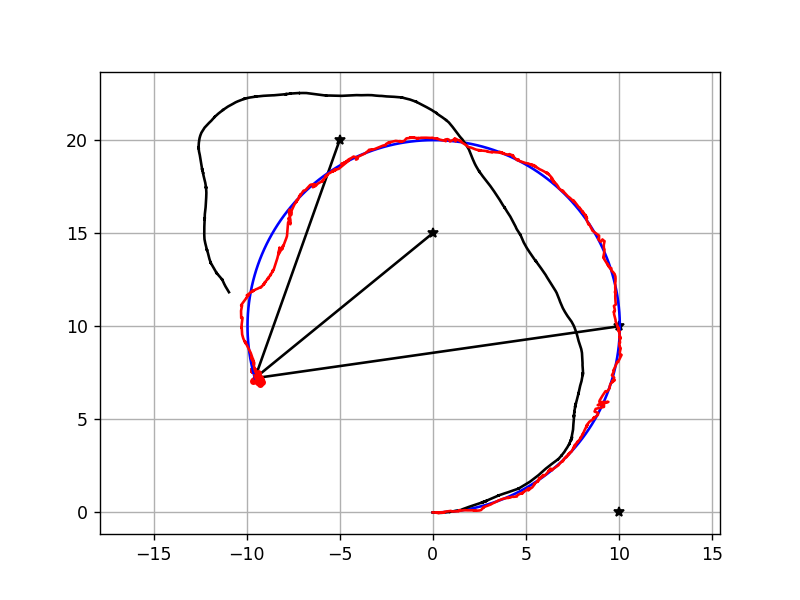

plot_covariance_ellipse


In [103]:
if __name__ == '__main__':
    main()

In [104]:
import cv2
import glob

img_array = []
path ="./figures"

for filename in sorted(glob.glob(path+"/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

name = path+'/project.mp4'
out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'MP4V'), 5.0, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [7]:
z = np.zeros((0, 3))
print(z)

[]


In [12]:
rf_id = np.array([[10.0, 0.0],
                      [10.0, 10.0],
                      [0.0, 15.0],
                      [-5.0, 20.0]])
print(rf_id[:, 0])

[10. 10.  0. -5.]


In [14]:
Q_sim = np.diag([0.2]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2

print(Q_sim)
print(R_sim)

[[0.04]]
[[1.         0.        ]
 [0.         0.27415568]]
